In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [2]:
stock_symbol = "AAPL"  # Replace with any stock symbol
start_date = "2010-01-01"
end_date = "2024-01-01"

stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
print(stock_data.head())


[*********************100%***********************]  1 of 1 completed

Price          Close      High       Low      Open     Volume
Ticker          AAPL      AAPL      AAPL      AAPL       AAPL
Date                                                         
2010-01-04  6.447412  6.462175  6.398306  6.429939  493729600
2010-01-05  6.458560  6.495013  6.424516  6.465188  601904800
2010-01-06  6.355827  6.484167  6.349199  6.458559  552160000
2010-01-07  6.344078  6.386858  6.297984  6.379326  477131200
2010-01-08  6.386253  6.386856  6.298284  6.335641  447610800


In [3]:
closing_prices = stock_data['Close'].values.reshape(-1, 1)


In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)


In [5]:
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

time_steps = 60
X, y = create_sequences(scaled_data, time_steps)


In [6]:
split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)


Training set size: (2769, 60, 1)
Testing set size: (693, 60, 1)


In [7]:
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(units=1)  # Output layer
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
model.compile(optimizer='adam', loss='mean_squared_error')


In [9]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 14s 105ms/step - loss: 0.0069 - val_loss: 0.0055
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - loss: 6.8726e-04 - val_loss: 0.0056
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - loss: 5.5628e-04 - val_loss: 0.0014
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 5.7352e-04 - val_loss: 0.0024
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - loss: 5.2948e-04 - val_loss: 0.0027
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - loss: 4.2693e-04 - val_loss: 0.0013
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - loss: 5.2979e-04 - val_loss: 0.0011
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - loss: 5.1614e-04 - val_loss: 0.0016
Epoch 9/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 5.9623e-04 - val_loss: 0.0026
Epoch 10/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - loss: 4.0164e-04 - val_loss: 0.0011
Epoch 11/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 3.1685e-04 - val_loss: 0.0019
Epoch 12/50
87/

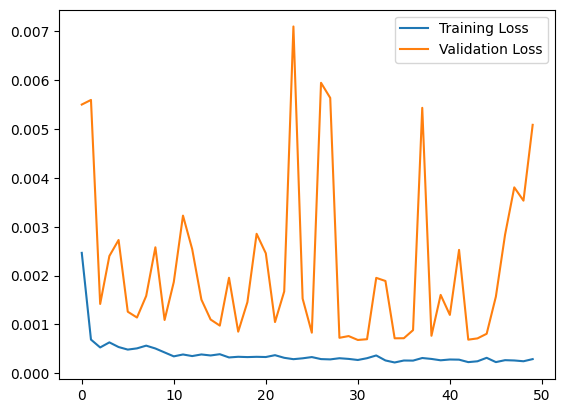

In [10]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()



In [11]:
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step


In [12]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 186.24188477932682


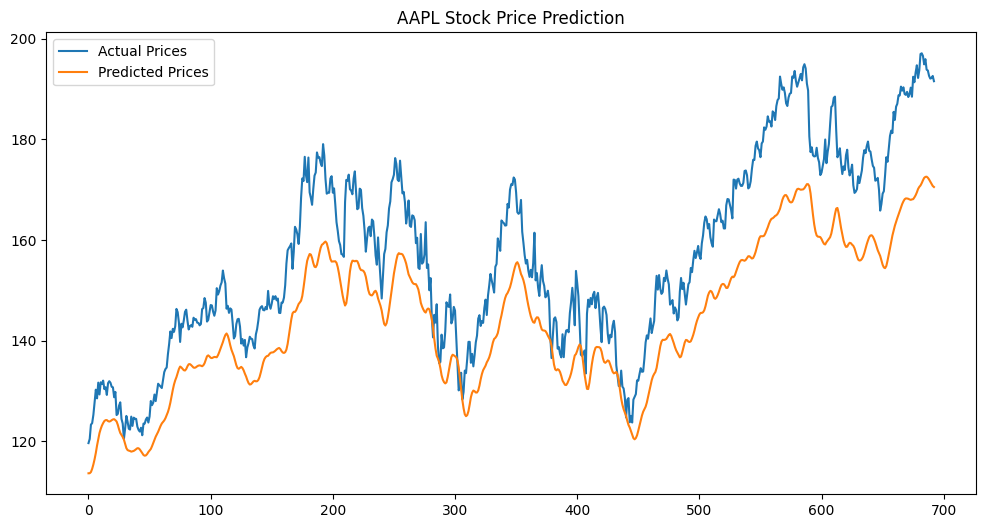

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Prices")
plt.plot(y_pred, label="Predicted Prices")
plt.legend()
plt.title(f"{stock_symbol} Stock Price Prediction")
plt.show()


In [14]:
last_60_days = scaled_data[-60:].reshape(1, 60, 1)
next_day_prediction = model.predict(last_60_days)
next_day_prediction = scaler.inverse_transform(next_day_prediction)
print("Predicted Stock Price for Next Day:", next_day_prediction[0][0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted Stock Price for Next Day: 170.3977
